# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os

C:\Users\babarohitk\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

### Balancing the Dataset

In [14]:
# Choosing positive and negative reviews
df_pos=final[final.Score == 1]
df_neg=final[final.Score == 0]

# Reducing reviews to 50k each from each class
df_pos = df_pos.sample(n=50000, random_state=0)
df_neg = df_neg.sample(n=50000, random_state=0)

# Shuffling dataset
final = pd.concat([df_pos,df_neg], ignore_index=True)
final['Score'].value_counts()

1    50000
0    50000
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

If you want a conversation item for a gathering then popcorn cobs may suffice. Everyone seems to find it interesting and fun but when it is time to eat the popcorn people have different taste and not everyone seems to like this popcorn. My sister likes it a lot, but then she likes hot air popcorn. While the flavor is good the popcorn is too dry for my enjoyment.<br /><br />Bottom line: This is a conversation starter with very good corn taste, but if you don't like hot air popcorn then you may not like this. Even though I don't like it I give it 4 starts because others I know do like it very much.
This is at a great price point. I do think that using it long term is the key. At first blush, it smells heavenly. All of their products do! I don't enjoy conditioners that smell like flowers or fruit per se, I like the ones that smell like good salon products. This conditioner fits the bill there! Plus, at just $5 it's a great price point for all those good ingredients. I will say that my hai

In [16]:
# Combining Summary into the Text
for i in range(len(final)):
    final['Text'].values[i]+=" "+final['Summary'].values[i]

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

If you want a conversation item for a gathering then popcorn cobs may suffice. Everyone seems to find it interesting and fun but when it is time to eat the popcorn people have different taste and not everyone seems to like this popcorn. My sister likes it a lot, but then she likes hot air popcorn. While the flavor is good the popcorn is too dry for my enjoyment.<br /><br />Bottom line: This is a conversation starter with very good corn taste, but if you don't like hot air popcorn then you may not like this. Even though I don't like it I give it 4 starts because others I know do like it very much.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

If you want a conversation item for a gathering then popcorn cobs may suffice. Everyone seems to find it interesting and fun but when it is time to eat the popcorn people have different taste and not everyone seems to like this popcorn. My sister likes it a lot, but then she likes hot air popcorn. While the flavor is good the popcorn is too dry for my enjoyment.Bottom line: This is a conversation starter with very good corn taste, but if you don't like hot air popcorn then you may not like this. Even though I don't like it I give it 4 starts because others I know do like it very much.
This is at a great price point. I do think that using it long term is the key. At first blush, it smells heavenly. All of their products do! I don't enjoy conditioners that smell like flowers or fruit per se, I like the ones that smell like good salon products. This conditioner fits the bill there! Plus, at just $5 it's a great price point for all those good ingredients. I will say that my hair felt good 

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    #To remove repetetive words like aa bbb ccc
    phrase = re.sub(r"(.)\1{2,}","", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Ordered this early in the year and find we use it for all sorts of dishes. Much more interesting than just brown or white rice, the combination produces a great flavor and great texture. We will be buying more after we use up our current order. Update May 2007: Have ordered more. This rice is excellent in a variety of dishes and is priced nicely too, at least compared to the alternatives in our local grocery store. My favorite recipe: Cook with some added bouillion or real chicken stock, add 1 to 2 tsp butter, add some dry or chopped onion, sage, basil, oregano and whatever else you feel like and cook as normal (15 to 20 minutes).


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

If you want a conversation item for a gathering then popcorn cobs may suffice. Everyone seems to find it interesting and fun but when it is time to eat the popcorn people have different taste and not everyone seems to like this popcorn. My sister likes it a lot, but then she likes hot air popcorn. While the flavor is good the popcorn is too dry for my enjoyment.<br /><br />Bottom line: This is a conversation starter with very good corn taste, but if you don't like hot air popcorn then you may not like this. Even though I don't like it I give it  starts because others I know do like it very much.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Ordered this early in the year and find we use it for all sorts of dishes Much more interesting than just brown or white rice the combination produces a great flavor and great texture We will be buying more after we use up our current order Update May 2007 Have ordered more This rice is excellent in a variety of dishes and is priced nicely too at least compared to the alternatives in our local grocery store My favorite recipe Cook with some added bouillion or real chicken stock add 1 to 2 tsp butter add some dry or chopped onion sage basil oregano and whatever else you feel like and cook as normal 15 to 20 minutes 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [25]:
preprocessed_reviews[500]

'Since we are allergic to dairy the seach for beverages that can be packed in a lunch has been difficult These are great I can store them in the closet and then just pop a pack in the fridge the night before school the kids take vanilla most days and I use chocolate as a treat on Fridays Very tasty alternative to soy milk'

# [4.4] Word2Vec

In [26]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [27]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('wonderful', 0.8812362551689148), ('fantastic', 0.8703834414482117), ('good', 0.8605716824531555), ('terrific', 0.7982119917869568), ('perfect', 0.7890355587005615), ('awesome', 0.7820137739181519), ('decent', 0.7818604707717896), ('fabulous', 0.775562584400177), ('nice', 0.7702491879463196), ('fine', 0.7602696418762207)]
[('nastiest', 0.8535391688346863), ('best', 0.8470589518547058), ('blandest', 0.7266293168067932), ('greatest', 0.6941407322883606), ('BEST', 0.6795321106910706), ('foulest', 0.675922691822052), ('tastiest', 0.652941107749939), ('WORST', 0.6325429677963257), ('vile', 0.6270695924758911), ('closest', 0.611495852470398)]


In [28]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  26571
sample words  ['If', 'you', 'want', 'a', 'conversation', 'item', 'for', 'gathering', 'then', 'popcorn', 'cobs', 'may', 'suffice', 'Everyone', 'seems', 'to', 'find', 'it', 'interesting', 'and', 'fun', 'but', 'when', 'is', 'time', 'eat', 'the', 'people', 'have', 'different', 'taste', 'not', 'everyone', 'like', 'this', 'My', 'sister', 'likes', 'lot', 'she', 'hot', 'air', 'While', 'flavor', 'good', 'too', 'dry', 'my', 'enjoyment', 'Bottom']


# [4.4.1.2] TFIDF weighted W2v

In [29]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [30]:
# Importing Library
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

In [31]:
X=preprocessed_reviews
X=np.array(X)
Y = np.array(final['Score'])

#Spliting Dataset to (Train-CrossValidation)70%,(Test)30%
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X, Y, test_size=0.3,random_state=0,stratify = Y)
X_cv, X_test, Y_cv, Y_test = train_test_split(X_cv, Y_cv, test_size=0.3,random_state=0,stratify = Y_cv)

# Common Function For Logistic Regression

In [32]:
# Fuction to compute best C Value using L1 Regularisation
def L1Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv):
    Roc_tr=[]
    Roc_cv=[]
    AUC_Max=0
    C_Optimal=0
    C_Set=[10**-4, 10**-2, 10**0, 10**2, 10**4]
           
    for i in C_Set:
        
        #Fitting the model on Training data
        LR =LogisticRegression(C=i, penalty='l1',n_jobs=-2)
        LR.fit(final_X_tr, Y_tr)
        
        #Predicting the Probability Estimates on Cross Validation data
        pred_cv = LR.predict_proba(final_X_cv)
        pred_cv=(pred_cv)[:,1]
        Roc_cv.append(roc_auc_score(Y_cv,pred_cv))
    
        #Predict the Probability Estimates on the Training data
        pred_tr = LR.predict_proba(final_X_tr)
        pred_tr=(pred_tr)[:,1]
        Roc_tr.append(roc_auc_score(Y_tr,pred_tr))
    
        #Store best C which has highest AUC score
        if roc_auc_score(Y_cv,pred_cv)>AUC_Max:
            C_Optimal=i
            AUC_Max=roc_auc_score(Y_cv,pred_cv)
    C=C_Optimal
    AUC=AUC_Max
    
    # Plotting AUC vs C graph of CV and Training Data
    plt.plot(np.log(C_Set),Roc_tr,label="AUC(train)")
    plt.plot(np.log(C_Set),Roc_cv ,label="AUC(cv)")
    plt.legend()
    plt.title('AUC Score vs C')
    plt.xlabel('C Values')
    plt.ylabel('AUC')
    plt.show()

    print("Best Alpha value = ",C)        
    print("Best Auc value = ",AUC)
    print("="*36)
    
    #Training the model using C-Optimal    
    LR=LogisticRegression(C=C, penalty='l1',n_jobs=-2)
    LR.fit(final_X_tr, Y_tr)
    #Predicting the Probability Estimates on Test data
    pred_test = LR.predict_proba(final_X_test)
    pred_test=(pred_test)[:,1]
    #Predict the Probability Estimates on the Training data
    pred_tr = LR.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]

    
    #fpr and tpr on Traing and Test Data
    fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_test)
    fpr1, tpr1, threshold1 = metrics.roc_curve(Y_tr, pred_tr)
    
    #Plotting Roc Curve
    plt.plot(fpr,tpr ,label="Test data")
    plt.plot(fpr1,tpr1 ,label="Train data")
    plt.legend()
    plt.title('ROC on optimal C')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
    #Confusion Matrix
    predic_test=LR.predict(final_X_test)
    conf_mat1 = confusion_matrix(Y_test, predic_test)
    
    #Confusion Matrix Heatmap
    class_label = ["-", "+"]
    df = pd.DataFrame(conf_mat1, index = class_label, columns = class_label)
    sns.heatmap(df, annot = True,fmt="d",cmap="Spectral")
    plt.title("Confusion Matrix(Test Data)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    
    return C,AUC,LR

In [33]:
# Fuction to compute best C Value using L2 Regularisation
def L2Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv):
    Roc_tr=[]
    Roc_cv=[]
    AUC_Max=0
    C_Optimal=0
    C_Set=[10**-4, 10**-2, 10**0, 10**2, 10**4]
           
    for i in C_Set:
        
        #Fitting the model on Training data
        LR =LogisticRegression(C=i, penalty='l2',n_jobs=-2)
        LR.fit(final_X_tr, Y_tr)
        
        #Predicting the Probability Estimates on Cross Validation data
        pred_cv = LR.predict_proba(final_X_cv)
        pred_cv=(pred_cv)[:,1]
        Roc_cv.append(roc_auc_score(Y_cv,pred_cv))
    
        #Predict the Probability Estimates on the Training data
        pred_tr = LR.predict_proba(final_X_tr)
        pred_tr=(pred_tr)[:,1]
        Roc_tr.append(roc_auc_score(Y_tr,pred_tr))
    
        #Store optimal C which has highest AUC score
        if roc_auc_score(Y_cv,pred_cv)>AUC_Max:
            C_Optimal=i
            AUC_Max=roc_auc_score(Y_cv,pred_cv)
    C=C_Optimal
    AUC=AUC_Max
    
    # Plotting AUC vs C graph of CV and Training Dataplt.plot(np.log(C_Set),Roc_cv ,label="AUC(cv)")
    plt.plot(np.log(C_Set),Roc_tr,label="AUC(train)")
    plt.plot(np.log(C_Set),Roc_cv ,label="AUC(cv)")
    plt.legend()
    plt.title('AUC Score vs C')
    plt.xlabel('C Values')
    plt.ylabel('AUC')
    plt.show()

    print("Best Alpha value = ",C)        
    print("Best Auc value = ",AUC)
    print("="*36)
    
    #Training the model using C-Optimal    
    LR=LogisticRegression(C=C, penalty='l2',n_jobs=-2)
    LR.fit(final_X_tr, Y_tr)
    before_pb=LR.coef_[0]
    #Predicting the Probability Estimates on Test data
    pred_test = LR.predict_proba(final_X_test)
    pred_test=(pred_test)[:,1]
    
    #Predict the Probability Estimates on the Training data
    pred_tr = LR.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]

    
    #fpr and tpr on Traing and Test Data
    fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_test)
    fpr1, tpr1, threshold1 = metrics.roc_curve(Y_tr, pred_tr)
    
    #Plotting Roc Curve
    plt.plot(fpr,tpr ,label="Test data")
    plt.plot(fpr1,tpr1 ,label="Train data")
    plt.legend()
    plt.title('ROC on optimal C')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
    #Confusion Matrix
    predic_test=LR.predict(final_X_test)
    conf_mat1 = confusion_matrix(Y_test, predic_test)
    
    #Confusion Matrix Heatmap
    class_label = ["-", "+"]
    df = pd.DataFrame(conf_mat1, index = class_label, columns = class_label)
    sns.heatmap(df, annot = True,fmt="d",cmap="Spectral")
    plt.title("Confusion Matrix(Test Data)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    
    return C,AUC,LR,before_pb

In [34]:
# Reviews to Bag of words
BOW = CountVectorizer()
final_X_tr=BOW.fit_transform(X_tr)
final_X_test=BOW.transform(X_test)
final_X_cv=BOW.transform(X_cv)

C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarni

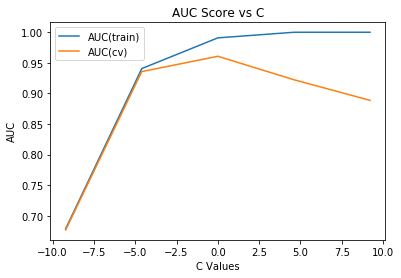

Best Alpha value =  1
Best Auc value =  0.960719387755102


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


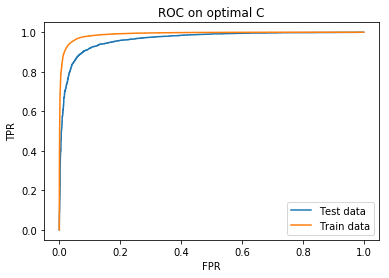

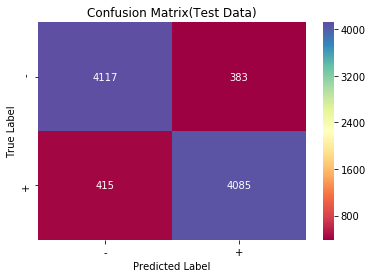

Wall time: 33min 38s


In [35]:
%%time
C1,Auc1,LR1=L1Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [36]:
# Counting Non-Zero Weights
LR = LogisticRegression(C=C1, penalty='l1');
LR.fit(final_X_tr, Y_tr);
NonZero_Weights = LR1.coef_
print(np.count_nonzero(NonZero_Weights))

5883


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarni

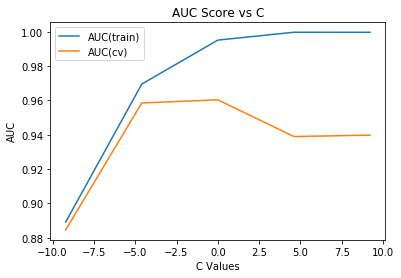

Best Alpha value =  1
Best Auc value =  0.9603225487528345


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


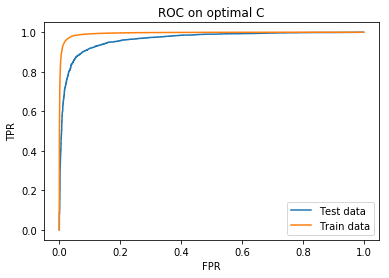

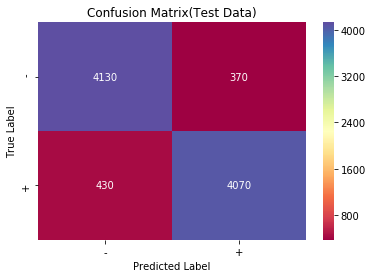

Wall time: 4min 6s


In [37]:
%%time
C2,Auc2,LR2,before_pb=L2Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [38]:
# Copy of Train Data for Pertubation test 
Perturbation_X_tr=final_X_tr.copy()
Perturbation_X_tr.data = Perturbation_X_tr.astype(float)

# Adding the epsilon(noise) to training data
Perturbation_X_tr.data.data +=0.001


In [39]:
# Training the model using C_Optimal with 
LR=LogisticRegression(C=C2, penalty='l2',n_jobs=-2)
LR.fit(Perturbation_X_tr.data, Y_tr)

# Assigning the weights after perturbation
after_pb=LR.coef_[0]
#print(lr.coef_[0][:10])

C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


In [40]:
# Adding 10power-6 to weights for avoiding divide by zero error 
before_pb = before_pb + 10**-6
after_pb = after_pb + 10**-6
l=[]
for i in range(len(before_pb)):
    l.append(((before_pb[i]-after_pb[i])/before_pb[i])*100)

Initial_Vector=np.absolute(l)      
Rev_Vector=sorted(np.absolute(l),reverse=True)
print(Rev_Vector[:10])

[56699.71923910934, 49876.50284160726, 46146.43596728306, 25775.999143927027, 22450.37100682142, 22450.37100682142, 19963.4586169254, 9641.964949043277, 9641.964949043277, 9641.964949043277]


In [41]:
# Percentiles from 0 to 100
for i in range(11):
    print(str(i*10)+'th Percentile = ' + str(np.percentile(Rev_Vector,i*10)))

0th Percentile = 3.2098123205697592e-06
10th Percentile = 0.019737341063855555
20th Percentile = 0.04109854576023204
30th Percentile = 0.06590895399758974
40th Percentile = 0.10101849614623507
50th Percentile = 0.16030862033820298
60th Percentile = 0.26990569520890584
70th Percentile = 0.48891471836527367
80th Percentile = 1.1179456440670494
90th Percentile = 6.014633058790764
100th Percentile = 56699.71923910934


In [42]:
# Percentiles from 90 to 100
for i in range(90,101):
    print(str(i)+'th Percentile ='+str(np.percentile(Rev_Vector,i)))

90th Percentile =6.014633058790764
91th Percentile =8.45305942552992
92th Percentile =13.118281614349053
93th Percentile =22.093809638533077
94th Percentile =33.4990878309573
95th Percentile =43.51441915378205
96th Percentile =51.84617459960881
97th Percentile =64.42873462081783
98th Percentile =93.53464016279351
99th Percentile =165.12137576575395
100th Percentile =56699.71923910934


Sudden Increase in percentiles from 90 to 100 

In [43]:
# Percentile from 99.1 to 100
for i in range(1,11):
    print(str(99+(10**-1)*i)+'th Percentile ='+str(np.percentile(Rev_Vector,99+(10**-1)*i)))

99.1th Percentile =187.60270062728836
99.2th Percentile =209.27136066049917
99.3th Percentile =225.15771131197238
99.4th Percentile =251.77324381867822
99.5th Percentile =305.3264319181041
99.6th Percentile =443.5966828817342
99.7th Percentile =590.2061518558806
99.8th Percentile =840.5827188920689
99.9th Percentile =2895.054266788722
100.0th Percentile =56699.71923910934


Huge increase in 100th Percentile

In [44]:
#100th percentile word
Initial_Vector=Initial_Vector.tolist()
Feature_names = BOW.get_feature_names()
i=Initial_Vector.index(np.percentile(Rev_Vector,100))
# Printing the word with high percentile score
print(Feature_names[i])

tabenero


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive and negative class from<font color='red'> SET 1</font>

In [45]:
#Getting feature names
Feature_names=BOW.get_feature_names()
d={}
# Looping through both Feature_names and Weights and creating dictionary.
for i in range(len(Feature_names)):
    d.update({Feature_names[i]:before_pb[i]})
    
# Sorting wrt to Weights.[kv[1]] contains weights
Weight_Sorted_Words=sorted(d.items(), key = lambda kv:(kv[1],kv[0]))

    
print("Top 10 +ve Features:   Weights")    
for i in range(10):
    print(Weight_Sorted_Words[-1*(i+1)])
print('='*50)
print("10 Top -ve Features:    Weights")
for i in range(11):
    print((Weight_Sorted_Words[i]))


Top 10 +ve Features:   Weights
('pleasantly', 2.9056609681178984)
('hooked', 2.404187064490006)
('skeptical', 2.256818841064821)
('pleased', 2.198766925688255)
('heaven', 2.1311087973862612)
('yum', 2.085811428939734)
('beat', 2.079362021086524)
('delicious', 2.072223192784723)
('drawback', 2.0175485466690057)
('awesome', 2.016732142650367)
10 Top -ve Features:    Weights
('worst', -3.0199188336187928)
('disappointing', -2.9420441878991066)
('disappointment', -2.7780523543932762)
('yuck', -2.6640619371511263)
('tasteless', -2.5559177037755503)
('cancelled', -2.5439980313101938)
('mediocre', -2.512085830196227)
('sounded', -2.370438376024689)
('awful', -2.2836522572461737)
('terrible', -2.228786138709393)
('horrible', -2.1872221608098643)


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [46]:
# Reviews to TF_IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10 )
final_X_tr=tf_idf_vect.fit_transform(X_tr)
final_X_test=tf_idf_vect.transform(X_test)
final_X_cv=tf_idf_vect.transform(X_cv)


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarni

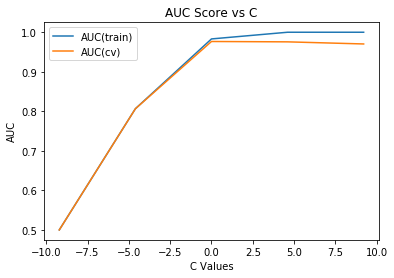

Best Alpha value =  1
Best Auc value =  0.9766083990929706


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


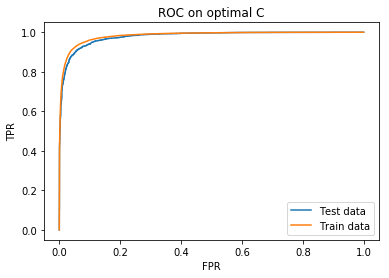

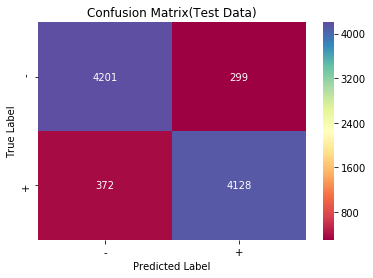

Wall time: 15.9 s


In [47]:
%%time
C3,Auc3,LR3=L1Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarni

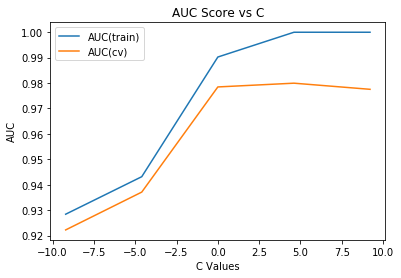

Best Alpha value =  100
Best Auc value =  0.9799546167800455


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


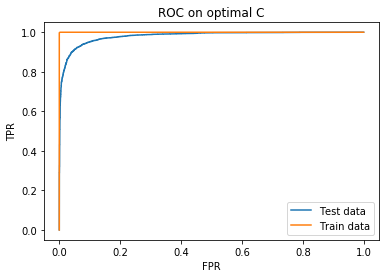

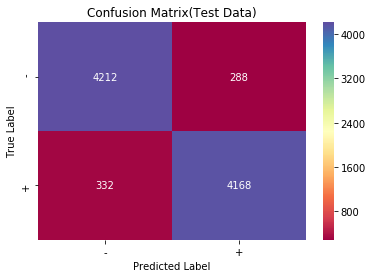

Wall time: 39.5 s


In [48]:
%%time
C4,Auc4,LR4,waste=L2Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive & negative class from<font color='red'> SET 2</font>

In [49]:
# Initialising weights
Weight_vect=LR4.coef_[0]

Feature_Names=tf_idf_vect.get_feature_names()
d={}

# Looping through both Feature_names and Weights and creating dictionary.
for i in range(len(Feature_Names)):
    d.update({Feature_Names[i]:Weight_vect[i]})
    
# Sorting wrt to Weights.[kv[1]] contains weights
Weight_Sorted_Words=sorted(d.items(), key = lambda kv:(kv[1], kv[0]))

    
print("Top 10 +ve features:       Weights")    
for i in range(10):
    print((Weight_Sorted_Words[-1*(i+1)]))
print('='*50)
print("top 10 -ve features:       Weights")
for i in range(10):
    print((Weight_Sorted_Words[i]))

Top 10 +ve features:       Weights
('great', 35.017431938854685)
('delicious', 32.01628693303568)
('good', 26.570788455079906)
('excellent', 25.648782228337577)
('best', 25.525237376886185)
('love this', 21.42646469862921)
('not too', 21.124365973783426)
('perfect', 19.924797343848727)
('awesome', 19.696885951426005)
('not bad', 19.012555278587595)
top 10 -ve features:       Weights
('not', -34.749507312911014)
('disappointing', -25.54757369261893)
('disappointed', -24.941873899366712)
('not worth', -24.325906706402026)
('awful', -23.48135182970104)
('worst', -23.0092929438611)
('terrible', -22.80350707470943)
('horrible', -21.738312994689608)
('not recommend', -21.162139180370513)
('not good', -20.771318303164843)


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [50]:
# AvgW2v
# compute average word2vec for each review.
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
final_X_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_tr): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_tr.append(sent_vec)
    
    
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())    
final_X_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_cv.append(sent_vec)    
    
    
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())    
final_X_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_test.append(sent_vec)

C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarni

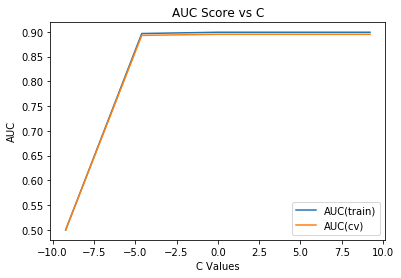

Best Alpha value =  1
Best Auc value =  0.8948576235827665


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


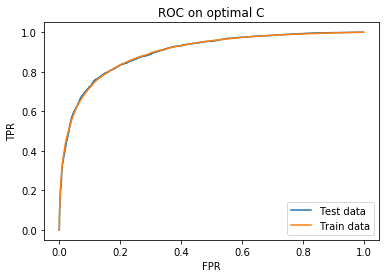

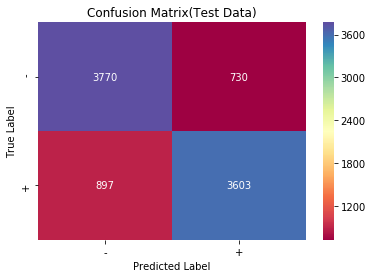

Wall time: 1min 26s


In [51]:
%%time
C5,Auc5,LR5=L1Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarni

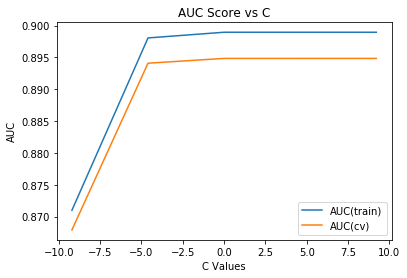

Best Alpha value =  1
Best Auc value =  0.8948496507936508


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


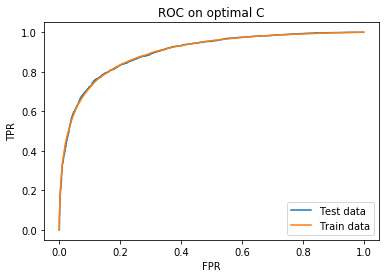

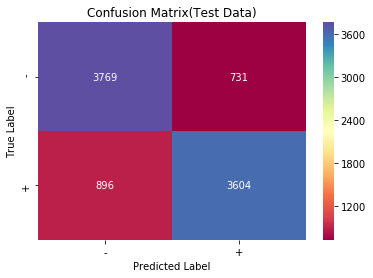

Wall time: 11.9 s


In [52]:
%%time
C6,Auc6,LR6,waste=L2Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [53]:
# Please write all the code with proper documentation
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
final_X_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_tr.append(sent_vec)
    row += 1

    
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
final_X_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_cv.append(sent_vec)
    row += 1 
    
    
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
final_X_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_test.append(sent_vec)
    row += 1  

C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarni

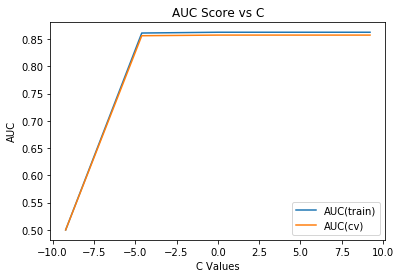

Best Alpha value =  1
Best Auc value =  0.8571089886621315


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


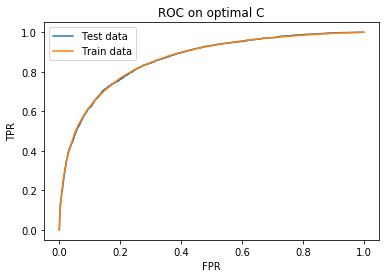

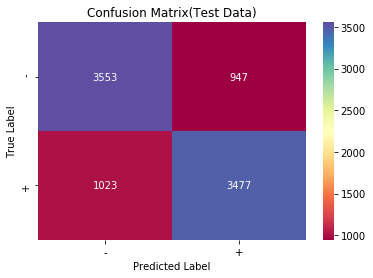

Wall time: 43.2 s


In [54]:
%%time
C7,Auc7,LR7=L1Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))
C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarni

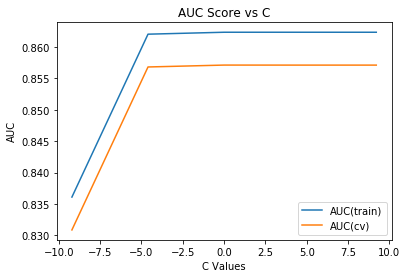

Best Alpha value =  1
Best Auc value =  0.8571009523809523


C:\Users\babarohitk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -2.
  " = {}.".format(self.n_jobs))


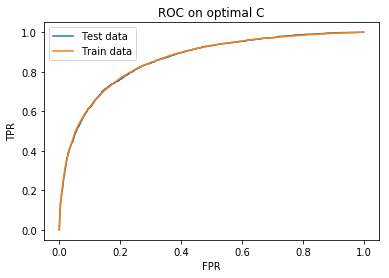

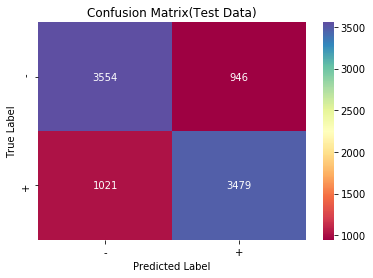

Wall time: 11.4 s


In [55]:
%%time
C8,Auc8,LR8,waste=L2Reg(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

# [6] Conclusions

In [56]:
from prettytable import PrettyTable    
Table = PrettyTable()
Table.field_names = ["Vector Type", "Regularization", "C_Optimal", "AUC"]
Table.add_row(["BOW","L1",C1,Auc1])
Table.add_row(["BOW","L2",C2,Auc2])
Table.add_row(["TF-IDF","L1",C3,Auc3])
Table.add_row(["TF-IDF","L2",C4,Auc4])
Table.add_row(["Avg-W2V","L1",C5,Auc5])
Table.add_row(["Avg-W2V","L2",C6,Auc6])
Table.add_row(["TF-IDF W2V","L1",C7,Auc7])
Table.add_row(["TF-IDF W2V","L2",C8,Auc8])
print(Table)

+-------------+----------------+-----------+--------------------+
| Vector Type | Regularization | C_Optimal |        AUC         |
+-------------+----------------+-----------+--------------------+
|     BOW     |       L1       |     1     | 0.960719387755102  |
|     BOW     |       L2       |     1     | 0.9603225487528345 |
|    TF-IDF   |       L1       |     1     | 0.9766083990929706 |
|    TF-IDF   |       L2       |    100    | 0.9799546167800455 |
|   Avg-W2V   |       L1       |     1     | 0.8948576235827665 |
|   Avg-W2V   |       L2       |     1     | 0.8948496507936508 |
|  TF-IDF W2V |       L1       |     1     | 0.8571089886621315 |
|  TF-IDF W2V |       L2       |     1     | 0.8571009523809523 |
+-------------+----------------+-----------+--------------------+
